<a href="https://colab.research.google.com/github/sondisonda/covid19SpreadForecast/blob/master/covid19SpreadForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#Importing data from github

import pandas as pd
path='https://raw.githubusercontent.com/sondisonda/covid19SpreadForecast/master/enriched_covid_19_week_2.csv'

df = pd.read_csv(path)


In [33]:
#Removing unnecessary collumns

df.drop(['Id'], 1, inplace=True)
df.drop(['Province_State'], 1, inplace=True)
df.drop(['Date'], 1, inplace=True)


In [34]:
#Spliting data in a training set and test set

lines_count = df.shape[0]
lines_per_country = 64

country_count = int(lines_count / lines_per_country)
train_country_count = int(country_count * (2/3))
test_country_count = int(country_count * (1/3))

train_rows_count = int(lines_count * (2/3))
test_rows_count = int(lines_count * (1/3))

print('Country count: ' + str(country_count))
print('Train rows count: ' + str(train_rows_count))
print('Test rows count: ' + str(test_rows_count))
print('Train country count: ' + str(train_country_count))
print('Test country count: ' + str(test_country_count))

Country count: 294
Train rows count: 12544
Test rows count: 6272
Train country count: 196
Test country count: 98


In [35]:
#Data simplification

simplified_df = df[['ConfirmedCases','total_pop']]

simplified_df.shape


(18816, 2)

In [36]:
#Data normalization

from sklearn.preprocessing import MinMaxScaler
from numpy import array


scaler = MinMaxScaler()

reshaped = array(simplified_df.ConfirmedCases.values).reshape(-1, 1)
scaler.fit(reshaped)
normalized = scaler.transform(reshaped)
simplified_df['ConfirmedCases'] = normalized


reshaped = array(simplified_df.total_pop.values).reshape(-1, 1)
scaler.fit(reshaped)
normalized = scaler.transform(reshaped)
simplified_df['total_pop'] = normalized

simplified_df.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ConfirmedCases,total_pop
count,18816.000000,18816.000000
mean,0.004613,0.172518
std,0.048129,0.310446
min,0.000000,0.000000
25%,0.000000,0.006149
50%,0.000000,0.025867
75%,0.000202,0.232174
max,1.000000,1.000000


In [37]:
#Data assignment

x_train = simplified_df.head(train_rows_count)
x_test = simplified_df.tail(test_rows_count)


In [38]:
y_train = x_train['ConfirmedCases']
y_test = x_test['ConfirmedCases']

In [39]:
#Preparing train data

import numpy as np
from numpy import array

x_days_train = list()
y_days_train = list()
length = lines_per_country
country_count = train_country_count
for i in range(0,length*country_count,length):
    x_day_train = x_train[i:i+length-1]
    x_days_train.append(x_day_train.values)
    y_day_train = y_train[i+length-1:i+length]
    y_days_train.append(y_day_train.values)


x_train = array(x_days_train)
print(x_train.shape)
y_train = array(y_days_train)
print(y_train.shape)

x_train = x_train.reshape(train_country_count, 63, 2)
print(x_train.shape)


(196, 63, 2)
(196, 1)
(196, 63, 2)


In [40]:
#Preparing test data

x_days_test = list()
y_days_test = list()
length = lines_per_country
country_count = test_country_count
for i in range(0,length*country_count,length):
    x_day_test = x_test[i:i+length-1]
    x_days_test.append(x_day_test.values)
    y_day_test = y_test[i+length-1:i+length]
    y_days_test.append(y_day_test.values)


x_test = array(x_days_test)
print(x_test.shape)
y_test = array(y_days_test)
print(y_test.shape)

x_test = x_test.reshape(test_country_count, 63, 2)
print(x_test.shape)

(98, 63, 2)
(98, 1)
(98, 63, 2)


In [41]:
#Creating and training  model

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


n_steps = 63
n_features = 2
n_batch = 4
model = Sequential()
model.add(LSTM(16, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(x_train, y_train, epochs=50, batch_size=n_batch, validation_data=(x_test, y_test),verbose=0, shuffle=False)


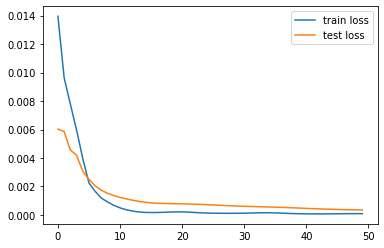

In [44]:
#Evaluating model

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

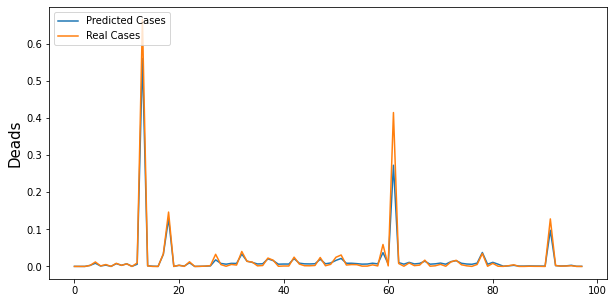

In [48]:
#Comparing results

import matplotlib.pyplot as plt

predictions = model.predict(x_test)

plt.figure(figsize = (10,5))
plt.plot(range(len(predictions)),predictions, label="Predicted Cases")
plt.plot(range(len(y_test)),y_test, label="Real Cases")
plt.ylabel('Deads',fontsize=15)
plt.legend(loc="upper left")
plt.show()

In [50]:
#Model save

model.save("model.h5")
